In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arch import arch_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# ------------------------------
# DOWNLOAD DATA & SANITY CHECK
# ------------------------------
ticker = 'SPY'
start_date = '2010-01-01'
end_date   = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
if data.empty:
    raise ValueError(
        f"No data returned for {ticker} in range [{start_date}, {end_date}]."
        " Confirm the ticker or date range are correct."
    )

# ------------------------------------------------------------------------
# CALCULATE LOG RETURNS
#    - log_return(t) = ln(AdjClose_t / AdjClose_(t-1))
#    - Drop the first row because it is NaN after shift
# ------------------------------------------------------------------------
data.columns = data.columns.get_level_values(0)
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data.dropna(subset=['log_return'], inplace=True)

returns = data['log_return']  # Fit GARCH on 'returns'

print("Number of total daily returns:", len(returns))
print("Date range:", returns.index[0], "->", returns.index[-1])


[*********************100%***********************]  1 of 1 completed

Number of total daily returns: 3521
Date range: 2010-01-05 00:00:00 -> 2023-12-29 00:00:00


In [ ]:
# ------------------------------------------------------------------------
# FIT GARCH(1,1) ON FIRST 90%
#    - Model volatility on the first 90% of daily returns
#    - arch_model(..., mean='Zero', vol='Garch', p=1, q=1)
# ------------------------------------------------------------------------
train_size = int(len(returns) * 0.9)
train_returns = returns.iloc[:train_size]

am = arch_model(train_returns, mean='Zero', vol='Garch', p=1, q=1)
garch_fit = am.fit(disp='off')

print("\nGARCH fit complete.")
print("GARCH training samples:", len(train_returns))
print("GARCH training last date:", train_returns.index[-1])


In [ ]:
# ------------------------------------------------------------------------
# ASSIGN IN-SAMPLE GARCH VOL & FILL OUT-OF-SAMPLE
#    - data['garch_volatility'] = sqrt(conditional_volatility) in-sample
#    - fill out-of-sample portion with 0 so those rows remain
# ------------------------------------------------------------------------
data['garch_volatility'] = np.nan

in_sample_vol = np.sqrt(garch_fit.conditional_volatility)
# Align these in-sample volatilities with train_returns.index
data.loc[train_returns.index, 'garch_volatility'] = in_sample_vol

data['garch_volatility'].fillna(0, inplace=True)

In [30]:
# ------------------------------------------------------------------------
# BUILD THE FEATURE SET
#    - 2 columns: [log_return, garch_volatility]
# ------------------------------------------------------------------------
features = data[['log_return', 'garch_volatility']]

print("\nFeature DataFrame shape:", features.shape)
print(features.tail(5))


Feature DataFrame shape: (3521, 2)
Price       log_return  garch_volatility
Date                                    
2023-12-22    0.002008               0.0
2023-12-26    0.004214               0.0
2023-12-27    0.001807               0.0
2023-12-28    0.000378               0.0
2023-12-29   -0.002899               0.0


In [31]:
# ------------------------------------------------------------------------
# SCALE FEATURES & CREATE LSTM SEQUENCES
#    - Use StandardScaler on 2 columns
#    - Make X,y with sliding windows of length=10
# ------------------------------------------------------------------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)  # shape: (N, 2)

def create_sequences(data_array, seq_length=10):
    """
    Create sequences for LSTM.
      X_list: each item is a [seq_length x 2] array
      y_list: next-step volatility (column=1 in data_array).
    """
    X_list, y_list = [], []
    for i in range(seq_length, len(data_array)):
        X_list.append(data_array[i - seq_length : i])
        y_list.append(data_array[i, 1])  # Vol is column index=1
    return np.array(X_list), np.array(y_list)

sequence_length = 10
X, y = create_sequences(scaled_features, seq_length=sequence_length)

print("\nAfter sequence creation:")
print("Total sequences (X) =", len(X))
print("X shape:", X.shape, "// y shape:", y.shape)



After sequence creation:
Total sequences (X) = 3511
X shape: (3511, 10, 2) // y shape: (3511,)


In [32]:
# ------------------------------------------------------------------------
# SPLIT SEQUENCES FOR LSTM (90% train / 10% test)
# ------------------------------------------------------------------------
train_size_seq = int(0.9 * len(X))
X_train, X_test = X[:train_size_seq], X[train_size_seq:]
y_train, y_test = y[:train_size_seq], y[train_size_seq:]

print("\nLSTM Train sequences:", X_train.shape, "Test sequences:", X_test.shape)


LSTM Train sequences: (3159, 10, 2) Test sequences: (352, 10, 2)


In [ ]:
# ------------------------------------------------------------------------
# BUILD & TRAIN THE BIDIRECTIONAL LSTM
#    - Do 10 epochs, batch_size=32, MSE loss
# ------------------------------------------------------------------------
model = Sequential()
model.add(
    Bidirectional(
        LSTM(64, return_sequences=False),
        input_shape=(sequence_length, X.shape[2])
    )
)
model.add(Dropout(0.2))
model.add(Dense(1))  # One output: predicted volatility
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\nLSTM training complete.")

c:\Users\jason\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1507 - val_loss: 2.2238
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 - val_loss: 2.3438
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 2.8021
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 4.2801
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 5.1798
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 4.3662
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 5.4585
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 5.3891
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 6.8953
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 6.2320

LSTM training complete.


In [34]:
# ------------------------------------------------------------------------
# ITERATIVE FORECAST FOR LAST 10%
#    - Step forward from the final 'sequence_length' train rows
#      and repeatedly feed the next log_return with the predicted vol
# ------------------------------------------------------------------------
predicted_vols = []

# "input_seq" is the final window from training
input_seq = scaled_features[train_size_seq : train_size_seq + sequence_length].copy()

for i in range(len(X_test)):
    # Model expects shape: (1, seq_length, 2)
    inp_reshaped = np.reshape(input_seq, (1, sequence_length, X.shape[2]))
    pred = model.predict(inp_reshaped, verbose=0)[0][0]  # single float
    predicted_vols.append(pred)
    
    # SHIFT: inject next log_return + predicted vol
    if train_size_seq + sequence_length + i < len(scaled_features):
        next_log_return = scaled_features[train_size_seq + sequence_length + i, 0]
        new_feature = np.array([next_log_return, pred])
        input_seq = np.vstack([input_seq[1:], new_feature])

predicted_vols = np.array(predicted_vols)

In [35]:
print("\nLength of predicted_vols:", len(predicted_vols))
print("First 10 predictions:", predicted_vols[:10])


Length of predicted_vols: 352
First 10 predictions: [ 0.21960816  0.06256973 -0.00987995  0.6320748   0.4644584   0.7421699
  0.57613623  0.40457895  0.28373396  0.15246509]


In [ ]:
# ------------------------------------------------------------------------
# INVERSE-TRANSFORM VOL & APPLY SMOOTHING
#     - Column=0 was log_return, column=1 was volatility
#     - Apply a rolling(3, min_periods=1).mean()
# ------------------------------------------------------------------------
vol_mean = scaler.mean_[1]
vol_std  = np.sqrt(scaler.var_[1])

predicted_vols_unscaled = predicted_vols * vol_std + vol_mean

predicted_vols_smooth = (
    pd.Series(predicted_vols_unscaled)
      .rolling(window=3, min_periods=1)
      .mean()
)

print("\npredicted_vols_smooth.head(10):")
print(predicted_vols_smooth.head(10))


predicted_vols_smooth.head(10):
0    0.092143
1    0.089307
2    0.087490
3    0.092455
4    0.097294
5    0.106347
6    0.105674
7    0.104953
8    0.099434
9    0.094334
dtype: float64


In [37]:
# ------------------------------------------------------------------------
# DEFINE THE DATE RANGE FOR PLOTTING LSTM PREDICTIONS
#     - GARCH train ends at the last date in train_returns
#     - Slice data.index accordingly
# ------------------------------------------------------------------------
garch_train_end_date = train_returns.index[train_size - 1]  # last in-sample date
garch_train_end_idx  = data.index.get_loc(garch_train_end_date) + 1

# Get the final 10% length
test_len = len(predicted_vols_smooth)

lstm_pred_dates = data.index[garch_train_end_idx : garch_train_end_idx + test_len]

print("\nPlot range for LSTM predictions:", lstm_pred_dates[0], "->", lstm_pred_dates[-1])


Plot range for LSTM predictions: 2022-08-05 00:00:00 -> 2023-12-28 00:00:00


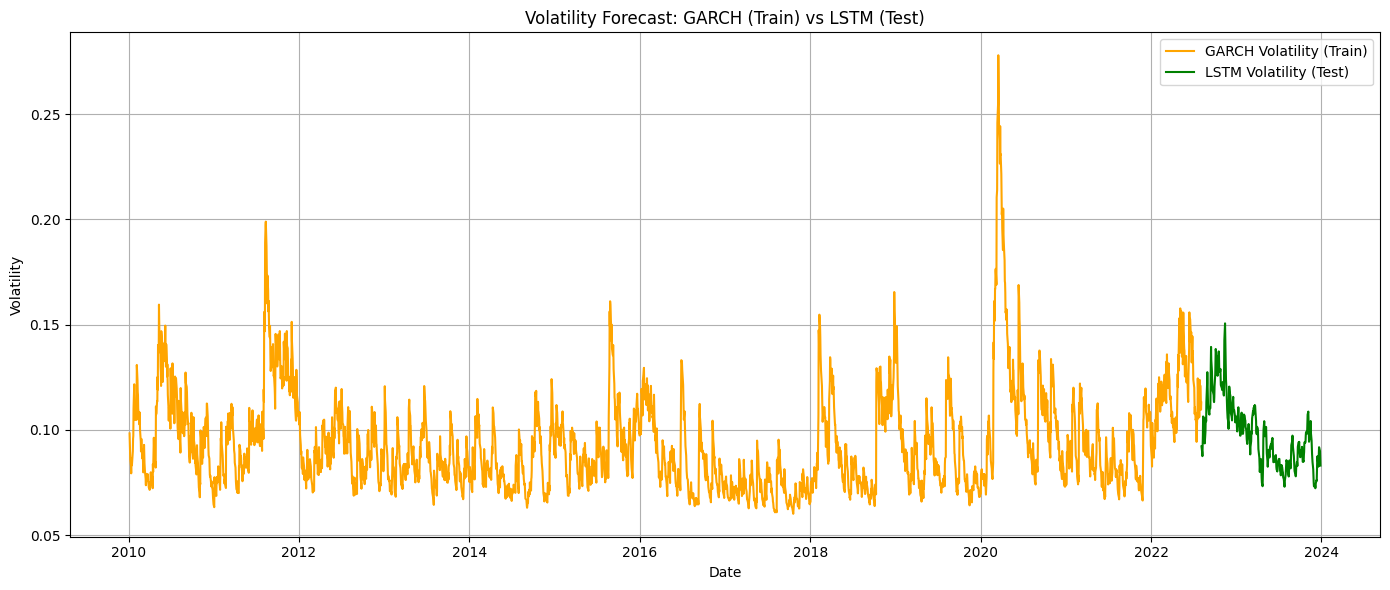

In [38]:
# ------------------------------------------------------------------------
# PLOT RESULTS
#     - ORANGE: GARCH in-sample
#     - GREEN: LSTM out-of-sample
# ------------------------------------------------------------------------
plt.figure(figsize=(14,6))

plt.plot(
    data.index[:garch_train_end_idx],
    data['garch_volatility'].iloc[:garch_train_end_idx],
    color='orange',
    label='GARCH Volatility (Train)'
)

plt.plot(
    lstm_pred_dates,
    predicted_vols_smooth.values,
    color='green',
    label='LSTM Volatility (Test)'
)

plt.title('Volatility Forecast: GARCH (Train) vs LSTM (Test)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

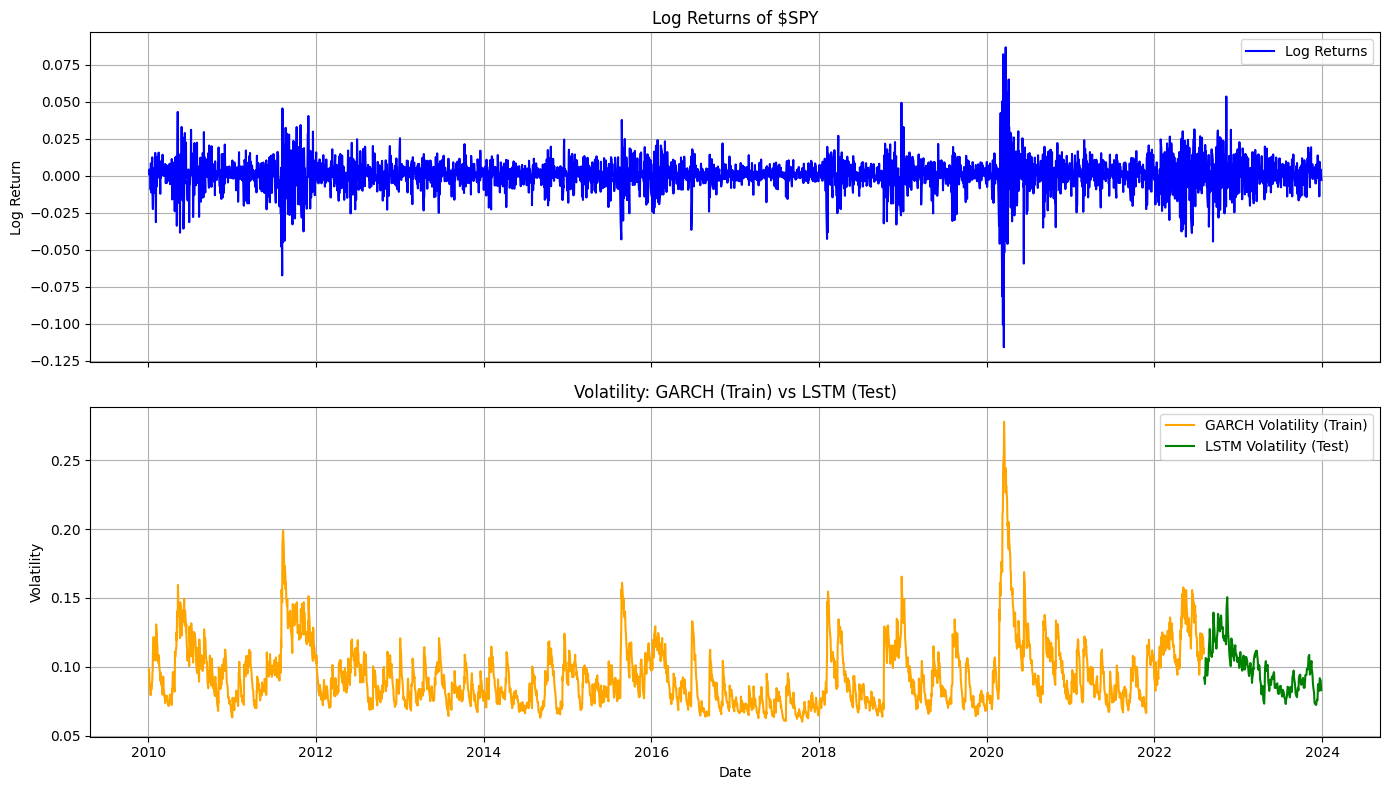

In [39]:
# Plot log returns and both GARCH & LSTM volatility
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Top subplot: Log Returns ---
ax[0].plot(data.index, data['log_return'], label='Log Returns', color='blue')
ax[0].set_title(f'Log Returns of ${ticker}')
ax[0].set_ylabel('Log Return')
ax[0].legend()
ax[0].grid(True)

# --- Bottom subplot: Volatility ---
# GARCH volatility (in-sample)
ax[1].plot(
    data.index[:garch_train_end_idx],
    data['garch_volatility'].iloc[:garch_train_end_idx],
    label='GARCH Volatility (Train)',
    color='orange'
)

# LSTM volatility (out-of-sample)
ax[1].plot(
    lstm_pred_dates,
    predicted_vols_smooth.values,
    label='LSTM Volatility (Test)',
    color='green'
)

ax[1].set_title('Volatility: GARCH (Train) vs LSTM (Test)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volatility')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

352


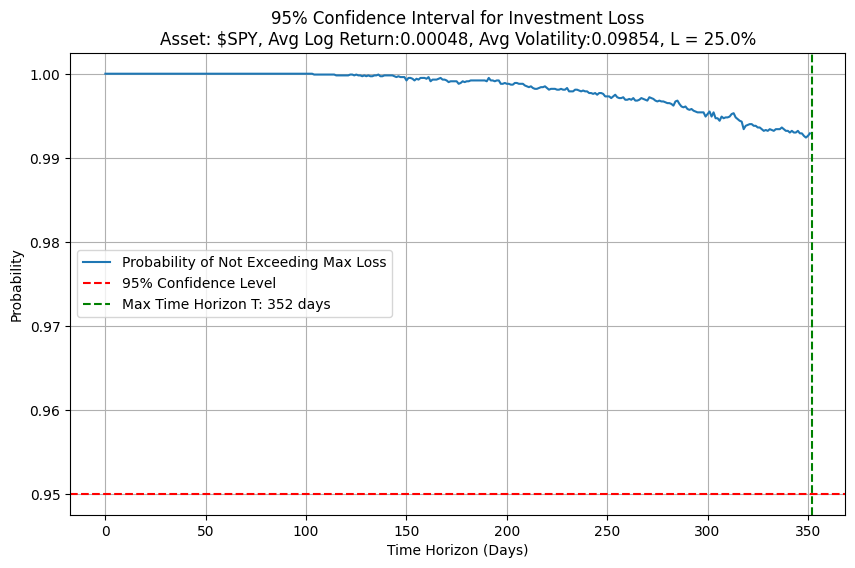

Maximum time horizon T: 352 days


In [40]:
def monte_carlo_simulation(S0, predicted_volatility, mu, max_loss, confidence_level, dt=1/252, num_simulations=10000):
    num_days = len(predicted_volatility)
    simulated_prices = np.zeros((num_simulations, num_days))


    for i in range(num_simulations):
        price = S0
        prices = []
        for sigma in predicted_volatility:
            daily_return = np.random.normal(mu * dt, sigma * np.sqrt(dt))
            price *= np.exp(daily_return)
            prices.append(price)
        simulated_prices[i, :] = prices

    # Calculate the probability of not exceeding the max loss for each time horizon
    loss_threshold = S0 - max_loss
    probabilities = np.mean(simulated_prices >= loss_threshold, axis=0)

    # Find the maximum time horizon T satisfying the confidence level
    max_time = np.argmax(probabilities < confidence_level)

    if probabilities[max_time] >= confidence_level:
        max_time = num_days  # The entire horizon satisfies the confidence level

    return max_time, probabilities

# Example Usage
S0 = 1000  # Initial investment
average_vol = np.mean(predicted_vols_smooth)
print(len(predicted_vols_smooth))
mu = np.mean(train_returns)  # Example daily return
risk_averse_percent = 0.25
max_loss = S0 * risk_averse_percent  # Maximum allowable loss ($100)
confidence_level = 0.95  # 95% confidence interval

max_time, probabilities = monte_carlo_simulation(S0, predicted_vols_smooth, mu, max_loss, confidence_level)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(probabilities, label="Probability of Not Exceeding Max Loss")
plt.axhline(confidence_level, color='red', linestyle='--', label=f"{confidence_level*100:.0f}% Confidence Level")
plt.axvline(max_time, color='green', linestyle='--', label=f"Max Time Horizon T: {max_time} days")
plt.title(f"95% Confidence Interval for Investment Loss\nAsset: ${ticker}, Avg Log Return:{mu:.5f}, Avg Volatility:{average_vol:.5f}, L = {risk_averse_percent*100}%")
plt.xlabel("Time Horizon (Days)")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()

print(f"Maximum time horizon T: {max_time} days")

0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
1.01


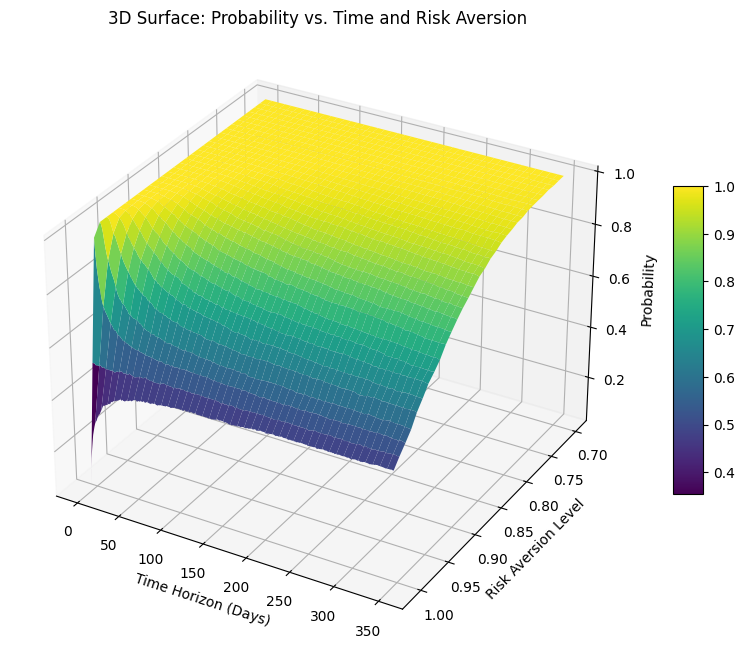

In [41]:
# Monte Carlo Simulation
def monte_carlo_simulation(S0, predicted_volatility, mu, max_loss, confidence_level, dt=1/252, num_simulations=10000):
    num_days = len(predicted_volatility)
    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price = S0
        prices = []
        for sigma in predicted_volatility:
            daily_return = np.random.normal(mu * dt, sigma * np.sqrt(dt))
            price *= np.exp(daily_return)
            prices.append(price)
        simulated_prices[i, :] = prices

    loss_threshold = S0 - max_loss
    probabilities = np.mean(simulated_prices >= loss_threshold, axis=0)

    max_time = np.argmax(probabilities < confidence_level)
    if probabilities[max_time] >= confidence_level:
        max_time = num_days

    return max_time, probabilities


# 3D Surface Plot
S0 = 1000
mu = np.mean(returns)
max_loss = 1000
confidence_level = 0.95
risk_aversion_levels = np.around(np.arange(0.7, 1.01, 0.01), decimals = 2)
time_horizons = np.arange(len(predicted_vols_smooth))
probability_surface = []

for risk_aversion in risk_aversion_levels:
    print(risk_aversion)
    adjusted_max_loss = max_loss * (1 - risk_aversion)
    _, probabilities = monte_carlo_simulation(
        S0=S0,
        predicted_volatility=predicted_vols_smooth,
        mu=mu,
        max_loss=adjusted_max_loss,
        confidence_level=confidence_level,
    )
    probability_surface.append(probabilities)

probability_surface = np.array(probability_surface)

# Plotting the 3D Surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(time_horizons, risk_aversion_levels)
surf = ax.plot_surface(X, Y, probability_surface, cmap='viridis')

ax.set_xlabel('Time Horizon (Days)')
ax.set_ylabel('Risk Aversion Level')
ax.invert_yaxis()  # Flip the Risk Aversion axis (y-axis)
ax.set_zlabel('Probability')
ax.set_title('3D Surface: Probability vs. Time and Risk Aversion')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

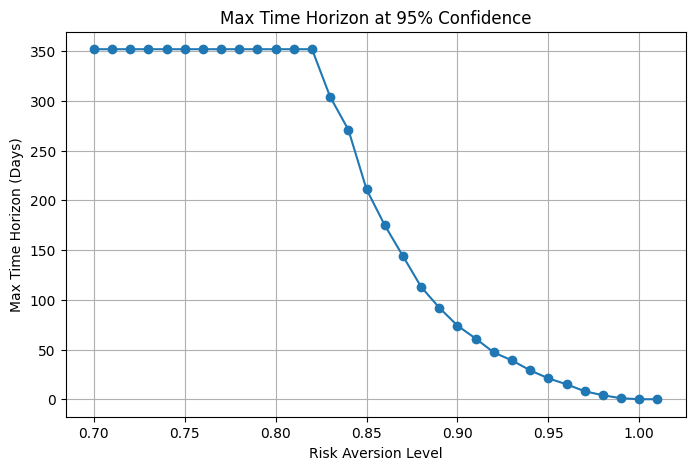

Sensitivity results (days of horizon per 0.01 step in RA):
 RA 0.70 -> 0.71: dT = 0.00 days / 0.01 in RA
 RA 0.71 -> 0.72: dT = 0.00 days / 0.01 in RA
 RA 0.72 -> 0.73: dT = 0.00 days / 0.01 in RA
 RA 0.73 -> 0.74: dT = 0.00 days / 0.01 in RA
 RA 0.74 -> 0.75: dT = 0.00 days / 0.01 in RA
 RA 0.75 -> 0.76: dT = 0.00 days / 0.01 in RA
 RA 0.76 -> 0.77: dT = 0.00 days / 0.01 in RA
 RA 0.77 -> 0.78: dT = 0.00 days / 0.01 in RA
 RA 0.78 -> 0.79: dT = 0.00 days / 0.01 in RA
 RA 0.79 -> 0.80: dT = 0.00 days / 0.01 in RA
 RA 0.80 -> 0.81: dT = 0.00 days / 0.01 in RA
 RA 0.81 -> 0.82: dT = 0.00 days / 0.01 in RA
 RA 0.82 -> 0.83: dT = -4800.00 days / 0.01 in RA
 RA 0.83 -> 0.84: dT = -3300.00 days / 0.01 in RA
 RA 0.84 -> 0.85: dT = -6000.00 days / 0.01 in RA
 RA 0.85 -> 0.86: dT = -3600.00 days / 0.01 in RA
 RA 0.86 -> 0.87: dT = -3100.00 days / 0.01 in RA
 RA 0.87 -> 0.88: dT = -3100.00 days / 0.01 in RA
 RA 0.88 -> 0.89: dT = -2100.00 days / 0.01 in RA
 RA 0.89 -> 0.90: dT = -1800.00 days / 

In [42]:
def get_max_time_from_surface(prob_array, confidence_level):
    """
    Given a 1D array of probabilities over time for a fixed RA,
    return the max day T for which prob >= confidence_level.
    """
    T = np.argmax(prob_array < confidence_level)
    # If it never goes below confidence_level, set T = total length
    if prob_array[T] >= confidence_level:
        T = len(prob_array)
    return T

# Choose the confidence level we want to analyze
analyze_confidence = 0.95

max_times = []
for i, ra in enumerate(risk_aversion_levels):
    row_probs = probability_surface[i, :]  # Probability for all days at RA[i]
    T_i = get_max_time_from_surface(row_probs, analyze_confidence)
    max_times.append(T_i)

max_times = np.array(max_times)


# ============================================
# Plot Max Time Horizon vs. RA
# ============================================
plt.figure(figsize=(8,5))
plt.plot(risk_aversion_levels, max_times, marker='o')
plt.xlabel('Risk Aversion Level')
plt.ylabel('Max Time Horizon (Days)')
plt.title(f'Max Time Horizon at {analyze_confidence*100:.0f}% Confidence')
plt.grid(True)
plt.show()

# ============================================
# Sensitivity to Changes in RA
# ============================================
delta_RA = np.diff(risk_aversion_levels)
delta_T  = np.diff(max_times)

sensitivity = delta_T / delta_RA  # Days change in horizon per RA unit

print("Sensitivity results (days of horizon per 0.01 step in RA):")
for i in range(len(sensitivity)):
    print(f" RA {risk_aversion_levels[i]:.2f} -> {risk_aversion_levels[i+1]:.2f}"
          f": dT = {sensitivity[i]:.2f} days / {delta_RA[i]:.2f} in RA")

In [48]:
print(max_times)

[352 352 352 352 352 352 352 352 352 352 352 352 352 304 271 211 175 144
 113  92  74  61  47  39  29  21  15   8   4   1   0   0]


In [43]:
print("Risk Aversion Level | Max Time Horizon (Days) | Δ Time Horizon")
print("==============================================================")
prev_T = None
for ra, T in zip(risk_aversion_levels, max_times):
    if np.isclose(int(ra*100) % 5, 0):  # Filter only at 0.05 steps
        if prev_T is None:
            print(f"        {ra:.2f}       |         {T:>3}              |   N/A")
        else:
            delta_T = T - prev_T
            print(f"        {ra:.2f}       |         {T:>3}              |  {delta_T:>+4}")
        prev_T = T


Risk Aversion Level | Max Time Horizon (Days) | Δ Time Horizon
        0.70       |         352              |   N/A
        0.75       |         352              |    +0
        0.80       |         352              |    +0
        0.85       |         211              |  -141
        0.90       |          74              |  -137
        0.95       |          21              |   -53
        1.00       |           0              |   -21


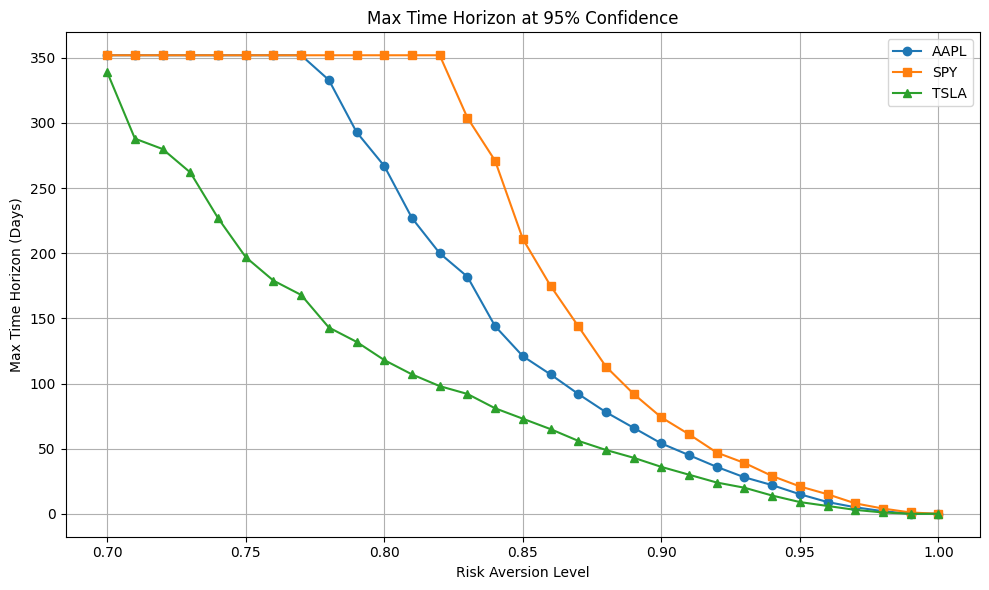

In [52]:
risk_aversion_levels_1 = np.arange(0.70, 1.00, 0.01)

# Max time horizons for each stock
aapl_times = np.array([352, 352, 352, 352, 352, 352, 352, 352, 333, 293, 267, 227, 200, 182, 144, 121,
                       107, 92, 78, 66, 54, 45, 36, 28, 22, 15, 9, 5, 2, 0, 0])
spy_times = np.array([352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 304, 271, 211,
                      175, 144, 113, 92, 74, 61, 47, 39, 29, 21, 15, 8, 4, 1, 0])

tsla_times = np.array([339, 288, 280, 262, 227, 197, 179, 168, 143, 132, 118, 107, 98, 92, 81, 73,
                       65, 56, 49, 43, 36, 30, 24, 20, 14, 9, 6, 3, 1, 0, 0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(risk_aversion_levels_1, aapl_times, label='AAPL', marker='o')
plt.plot(risk_aversion_levels_1, spy_times, label='SPY', marker='s')
plt.plot(risk_aversion_levels_1, tsla_times, label='TSLA', marker='^')

plt.xlabel('Risk Aversion Level')
plt.ylabel('Max Time Horizon (Days)')
plt.title('Max Time Horizon at 95% Confidence')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
def get_max_time_given_RA(
    RA,
    S0,
    predicted_volatility,
    mu,
    base_max_loss,
    confidence_level,
    dt=1/252,
    num_simulations=10000
):
    """
    Given a single risk-aversion (RA), runs the Monte Carlo
    and returns the max time horizon T such that probability >= confidence_level.
    """
    # Compute adjusted max loss
    adjusted_max_loss = base_max_loss * (1 - RA)
    
    # Run existing MC approach
    _, probabilities = monte_carlo_simulation(
        S0=S0,
        predicted_volatility=predicted_volatility,
        mu=mu,
        max_loss=adjusted_max_loss,
        confidence_level=confidence_level,
        dt=dt,
        num_simulations=num_simulations
    )
    
    # Derive max_time from the probability array
    # (Arg where prob drops below confidence_level)
    T = np.argmax(probabilities < confidence_level)
    if probabilities[T] >= confidence_level:
        T = len(probabilities)
        
    return T


In [45]:
def find_RA_for_desired_time(
    T_target,
    S0,
    predicted_volatility,
    mu,
    base_max_loss,
    confidence_level,
    dt=1/252,
    num_simulations=10000,
    RA_min=0.70,
    RA_max=1.00,
    step=0.01
):
    best_RA = None
    best_diff = float('inf')
    
    # Loop over possible RA values
    ra_values = np.arange(RA_min, RA_max+0.0001, step)
    
    for ra in ra_values:
        print(ra)
        T = get_max_time_given_RA(
            RA=ra,
            S0=S0,
            predicted_volatility=predicted_volatility,
            mu=mu,
            base_max_loss=base_max_loss,
            confidence_level=confidence_level,
            dt=dt,
            num_simulations=num_simulations
        )
        
        diff = abs(T - T_target)
        if diff < best_diff:
            best_diff = diff
            best_RA = ra
    
    return best_RA


In [46]:
desired_time = 150        # Trader wants 150 days
confidence_level = 0.95   # e.g., 95% confidence

ra_star = find_RA_for_desired_time(
    T_target       = desired_time,
    S0             = 1000,
    predicted_volatility = predicted_vols_smooth,
    mu             = np.mean(returns),
    base_max_loss  = 1000,
    confidence_level = confidence_level,
    dt            = 1/252,
    num_simulations = 10000,
    RA_min = 0.70,
    RA_max = 1.00,
    step   = 0.01
)

print(f"For T = {desired_time} days @ {confidence_level*100:.0f}% conf, RA = {ra_star:.2f}")

0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.8600000000000001
0.8700000000000001
0.8800000000000001
0.8900000000000001
0.9000000000000001
0.9100000000000001
0.9200000000000002
0.9300000000000002
0.9400000000000002
0.9500000000000002
0.9600000000000002
0.9700000000000002
0.9800000000000002
0.9900000000000002
1.0000000000000002
For T = 150 days @ 95% conf, RA = 0.87
